# Detect human using Faster-RCNN

In [1]:
# Imports
import torchvision.models as models
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch

## Load the model

In [2]:
# Load the pretrained model from pytroch
faster_rcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

## Read the data anotations

In [3]:
annotations_dir = './annotations/person_keypoints_train2017.json'
images_dir = './train2017/'

In [4]:
with open(annotations_dir, 'r') as f:
    json_data = json.load(f)

In [5]:
image_keypoints = json_data['categories'][0]['keypoints']
images_list = json_data['images']
ids_list = []
for each in json_data['annotations']:
    ids_list.append(each['image_id'])

## Helper functions

In [6]:
def pick_random_image():
    """
    Pick a random image and check if is is has annotations (human in image)
    """
    is_human = False
    random_image_name = np.random.choice(images_list, 1)[0]['file_name']
    while not (is_human):
        if (int(random_image_name[:-4]) not in ids_list):
            random_image_name = np.random.choice(images_list, 1)[0]['file_name']
        else:
            is_human = True
    img = plt.imread(images_dir + random_image_name)
    return img, random_image_name

def visualize_random_image():
    img, name = pick_random_image()
    print('Image shape: {}'.format(img.shape))
    plt.imshow(img)
    plt.show()

Image shape: (480, 640, 3)


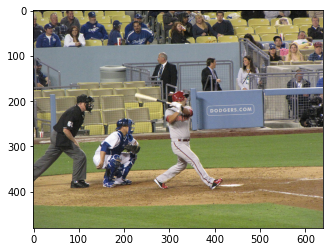

In [7]:
# Visualize a random image that contains only human(s)
visualize_random_image()

## Make a prediction using  Faster-RCNN

Image name: 000000450162.jpg
Image shape: (425, 640, 3)
Image is normalized and turned to tensor
Tensor shape: torch.Size([3, 425, 640])


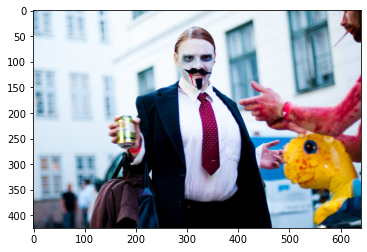

In [53]:
# Pull a random image from images
img, name=pick_random_image() 
# Normalize the image so every pixel value to be 0-1
norm_img = (img /255.)
# Turn the array into a torch tensor and change the order of dimensions (H,W,C) --> (C,H,W)
img_tensor= torch.from_numpy(norm_img).permute(2,0,1).float()

print("Image name: {}".format(name))
print("Image shape: {}".format(img.shape))
print("Image is normalized and turned to tensor")
print("Tensor shape: {}".format(img_tensor.shape))


plt.imshow(img)
plt.show()

In [54]:
device = torch.device('cuda')
# Set model in evaluation mode
faster_rcnn.eval()
# Send model and tensor to GPU
faster_rcnn.to(device)
img_tensor = img_tensor.to(device)
# Make prediciton
with torch.no_grad():
    results = faster_rcnn([img_tensor])

print("Predicted {} unique labels in this image".format(len(results[0]['labels'].unique())))

Predicted 15 unique labels in this image


## Plot the predictions

In [55]:
# Load the categoreies dictionary
categories_dir = './annotations/instances_val2017.json'
with open(categories_dir, 'r') as f:
    cat_data = json.load(f)

# Small function that translates the predicted labels into the name of each category
def translate_cats(label):
    for each in cat_data['categories']:
        if label== each['id']:
            return each['name']

In [56]:
# Make a linear color space for your labels
from matplotlib.pyplot import cm
labels_with_hiscore = [(label, score) for label, score in zip(results[0]['labels'], results[0]['scores']) if score>0.8]
colors=cm.rainbow(np.linspace(0,1,len(labels_with_hiscore)))

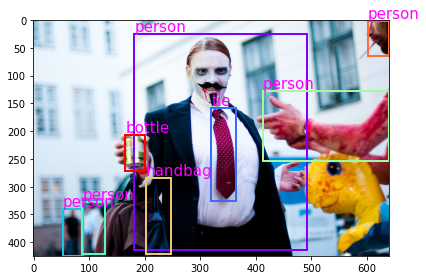

Label: person, Score: 99.81%
Label: tie, Score: 99.81%
Label: person, Score: 98.80%
Label: person, Score: 98.74%
Label: person, Score: 97.98%
Label: handbag, Score: 96.93%
Label: person, Score: 82.22%
Label: bottle, Score: 81.44%


In [57]:
fig, ax = plt.subplots(1)
labels = []
scores = []

for idx, each_box in enumerate(results[0]['boxes']):
    # Check only the predicitons for humans and with scoring accuracy more than 80%
    label = results[0]['labels'][idx].item()
    score = results[0]['scores'][idx].item()
    if score >= 0.8:
        labels.append(label)
        scores.append(score)
        x, y, w, h = each_box
        # Turn floats into int
        x, y, w, h =  int(np.ceil(x.item())), int(np.ceil(y.item())), int(np.ceil(w.item())), int(np.ceil(h.item()))
        ax.imshow(img)
        rect = patches.Rectangle((x, y), w-x, h-y,
                                 linewidth=2,ec=colors[idx], fc='none')
        ax.add_patch(rect)
        plt.text(x,y-5, translate_cats(label), c='magenta', size=15)

plt.tight_layout()
plt.show()

for idx, each in enumerate(labels):
    print("Label: {}, Score: {:.2f}%".format(translate_cats(each), scores[idx]*100))
